<a href="https://colab.research.google.com/github/kaitken17/colab_based_projects/blob/master/rnn_rl/gamblers_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from random import random
from random import randint

import matplotlib.pyplot as plt

In [ ]:
class GambleEnv():
  """ Environment for gambler's problem """

  def __init__(self, p_lose=0.5, max_state=100, start_state=50):
    self.p_lose = p_lose
    self.max_state = max_state

  def eval_reward(self, state):
    # Evalutes reward
    if state >= self.max_state:
      reward = 1
    elif state <= 0:
      reward = -1
    else:
      reward = 0
    return reward

  def gamble(self, state, action):
    """ Takes in a previous state and action and returns next state and reward 
    state: current amount of money  
    action: wager

    next_state: money
    reward: 1 if game is won , -1 if loss, otherwise 0
    """

    # Evalutes next state
    if random() > self.p_lose: # Success
      next_state = state + action
      # print(f'Agent Wins: {state} -> {next_state} (bet {action})')
    else: # Failure
      next_state = state - action
      # print(f'Agent Loses: {state} -> {next_state} (bet {action})')

    return next_state, self.eval_reward(next_state)

  def win_lose_vals(self, state, action):
    """ Evalutes all possible actions from a given state, used to update values """
    win_state = state + action
    win_reward = self.eval_reward(win_state)
    win_prob = 1 - self.p_lose

    lose_state = state - action
    lose_reward = self.eval_reward(lose_state)
    lose_prob = self.p_lose

    return win_state, win_reward, win_prob, lose_state, lose_reward, lose_prob

class GamblePolicy():
  """ A given policy for gambling, beloning to the agent
  
  policy: array of integers corresponding to action bet (running from 0 to max_state)
  
  """
  def __init__(self, env):
    """ Initializes based on a given policy """
    self.max_state = env.max_state
    # Inits policy as random integers between 1 and state_value
    self.policy = np.zeros((self.max_state+1), dtype=np.int32)
    for idx in range(1, self.policy.shape[0]): # Doesn't update 0 policy
      # self.policy[idx] = randint(1, idx)
      self.policy[idx] = 1


  def get_action(self, state):
    """ Returns an action based on a state (deterministic in this example) """
    # Converts state into corresponding index in policy
    return self.policy[state]

class GambleValues():
  """ 
  Holds values of a given state, as well as values of states given actions 
  
  s_vals: 1d array of estimated values (n_states)
  sa_vals: 2d array of estimated values (n_states, n_states)
  
  """
  def __init__(self, env):
    self.s_vals = np.zeros((env.max_state-1))
    self.sa_vals = -np.inf * np.ones((env.max_state-1, env.max_state-1))

class GambleAgent():
  """ Agent that gambles """
  def __init__(self, env, gamma=1.0):
    self.env = env
    self.policy = GamblePolicy(self.env)
    self.values = GambleValues(self.env)
    self.state = randint(1, env.max_state-1)
    self.gamma = gamma

  def bet(self):
    """ Gambling agent takes an action based on the state (doesn't act based on reward for this problem) """
    
    if self.state >= self.env.max_state:
      raise ValueError('Alreasdy won')
    if self.state <= 0:
      raise ValueError('Alreasdy lost')

    action = self.policy.get_action(self.state)
    self.state, reward = self.env.gamble(self.state, action)

  def bet_a_lot(self, trials=1000):
    """ Bets over a lot of trials to get an idea of how successful policy is """
    total_reward = 0
    total_wins = 0
    total_losses = 0
    for _ in range(trials):
      # Resets state
      self.state = randint(1, env.max_state-1)
      reward = 0
      while reward == 0:
        action = self.policy.get_action(self.state)
        self.state, reward = self.env.gamble(self.state, action)
      if reward > 0: total_wins += 1
      if reward < 0: total_losses += 1
      total_reward += reward

    print(f'Total Reward: {total_reward} (wins: {total_wins}, losses: {total_losses}, avg: {total_reward/trials})')

  def evaluate_values(self, thresh = 1e-3):
    """ Iteratively updates the values. Note this does this in place """
    deltas = np.ones((self.env.max_state - 1))

    # Finds s_vals with iterations
    while (deltas > thresh).any():
      # Evalutes the values of each state
      # print('s_vals:', self.values.s_vals)
      for state_idx in range(self.env.max_state - 1):
        old_value = self.values.s_vals[state_idx].copy()
        state = state_idx + 1 # Starts at state 1
        
        # Finds two possibilities in state
        action = self.policy.get_action(state)
        win_state, win_reward, win_prob, lose_state, lose_reward, lose_prob = self.env.win_lose_vals(state, action)
        # print('win_state:', win_state)
        # print('win_reward', win_reward)
        # print('win prob', win_prob)
        # print('lose_state:', lose_state)
        # print('lose_reward', lose_reward)
        # print('lose prob', lose_prob)
        # Updates value given possibilities
        state_val = 0.0
        if win_state >= self.env.max_state: # The value for this state is simply 0
          state_val += win_prob * win_reward
        else:
          state_val += win_prob * (win_reward + self.gamma * self.values.s_vals[win_state-1])
        if lose_state <= 0: # Value for this state is 0
          state_val += lose_prob * lose_reward
        else:
          state_val += lose_prob * (lose_reward + self.gamma * self.values.s_vals[lose_state-1])
        # print('state_val:', state_val)
        self.values.s_vals[state_idx] = state_val
        deltas[state_idx] = np.abs(old_value - self.values.s_vals[state_idx])
      # print(sdfsdfsdf)
    # Finds sa_vals using s_vals
    for state_idx in range(self.env.max_state - 1):
      for action_idx in range(state_idx+1): # All possible actions from a given state
        state = state_idx + 1
        action = action_idx + 1        
        win_state, win_reward, win_prob, lose_state, lose_reward, lose_prob = self.env.win_lose_vals(state, action)
        sa_val = 0.0
        if win_state >= self.env.max_state: # The value for this state is 0
          sa_val += win_prob * win_reward
        else:
          sa_val += win_prob * (win_reward + self.gamma * self.values.s_vals[win_state-1])
        if lose_state <= 0: # Value for this state is 0
          sa_val += lose_prob * lose_reward
        else:
          sa_val += lose_prob * (lose_reward + self.gamma * self.values.s_vals[lose_state-1])
        self.values.sa_vals[state_idx, action_idx] = sa_val

  def update_policy(self):
    """ Updates the policy based on sa_vals (just uses greedy to update) """
    # +1 is needed because sa_vals starts at state 1
    self.policy.policy[1:-1] = np.argmax(agent.values.sa_vals, axis=1) + 1

In [ ]:
env = GambleEnv(p_lose=0.6)
agent = GambleAgent(env, gamma=1.0)

In [ ]:
agent.bet_a_lot()

Total Reward: -182 (wins: 409, losses: 591, avg: -0.182)


In [ ]:
for _ in range(100):
  agent.bet_a_lot()
  agent.evaluate_values()
  agent.update_policy()

Total Reward: -976 (wins: 12, losses: 988, avg: -0.976)
Total Reward: -178 (wins: 411, losses: 589, avg: -0.178)
Total Reward: -208 (wins: 396, losses: 604, avg: -0.208)
Total Reward: -220 (wins: 390, losses: 610, avg: -0.22)
Total Reward: -202 (wins: 399, losses: 601, avg: -0.202)
Total Reward: -220 (wins: 390, losses: 610, avg: -0.22)
Total Reward: -202 (wins: 399, losses: 601, avg: -0.202)
Total Reward: -204 (wins: 398, losses: 602, avg: -0.204)
Total Reward: -166 (wins: 417, losses: 583, avg: -0.166)
Total Reward: -200 (wins: 400, losses: 600, avg: -0.2)
Total Reward: -214 (wins: 393, losses: 607, avg: -0.214)
Total Reward: -212 (wins: 394, losses: 606, avg: -0.212)
Total Reward: -228 (wins: 386, losses: 614, avg: -0.228)
Total Reward: -216 (wins: 392, losses: 608, avg: -0.216)
Total Reward: -210 (wins: 395, losses: 605, avg: -0.21)
Total Reward: -208 (wins: 396, losses: 604, avg: -0.208)
Total Reward: -206 (wins: 397, losses: 603, avg: -0.206)
Total Reward: -244 (wins: 378, losses

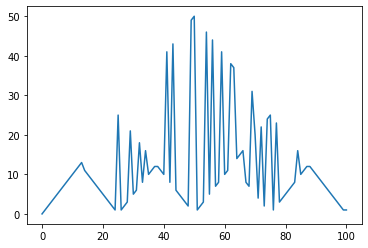

In [ ]:
plt.plot(agent.policy.policy)

In [ ]:
agent.evaluate_values()
print('Policy:', agent.policy.policy)
print('S vals:', agent.values.s_vals)
print('Max AS vals:', np.argmax(agent.values.sa_vals, axis=1))
print(agent.values.sa_vals[:10,:10])

Policy: [ 0  1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29
 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5
  4  3  2  1 24]
S vals: [-0.99722574 -0.99306425 -0.98682192 -0.97834948 -0.97121611 -0.9619991
 -0.95003502 -0.94105857 -0.93220159 -0.92092476 -0.90915907 -0.89560821
 -0.87924886 -0.86602157 -0.85680773 -0.84682281 -0.83466529 -0.82098221
 -0.80647322 -0.78947462 -0.77705899 -0.76201205 -0.74318186 -0.72550946
 -0.70228347 -0.67667089 -0.66921525 -0.65935741 -0.64618064 -0.63537119
 -0.62121835 -0.60073647 -0.59082454 -0.57675718 -0.55661687 -0.54125742
 -0.5203444  -0.49283921 -0.47784789 -0.46427794 -0.44680881 -0.4288415
 -0.40919147 -0.38425411 -0.362116   -0.34170393 -0.317935   -0.29110181
 -0.25987003 -0.22709901 -0.19583855 -0.18700969 -0.17719946 -0.16463514
 -0.15255486 -0.1373